In [281]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,Dataset
import datetime
from sklearn.model_selection import train_test_split # 训练集和测试集

In [282]:
data = pd.read_csv('/home/cyh/pcw/datasets/beijing/PRSA_data_2010.1.1-2014.12.31.csv')

data

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43819,43820,2014,12,31,19,8.0,-23,-2.0,1034.0,NW,231.97,0,0
43820,43821,2014,12,31,20,10.0,-22,-3.0,1034.0,NW,237.78,0,0
43821,43822,2014,12,31,21,10.0,-22,-3.0,1034.0,NW,242.70,0,0
43822,43823,2014,12,31,22,8.0,-22,-4.0,1034.0,NW,246.72,0,0


In [283]:
data = data.iloc[24:].fillna(method='ffill') # 保留24条后数据把空值设置为前一条数值

In [284]:
# 处理时间列
data['time'] = data.apply(lambda x: datetime.datetime(year=x['year'],
                                       month=x['month'],
                                       day=x['day'], 
                                       hour=x['hour']), 
                            axis=1) # 按行处理

data.set_index('time', inplace=True) # 按时间索引
data.drop(columns=['year', 'month', 'day', 'hour','No'], inplace=True)

In [285]:
# 独热编码
data = data.join(pd.get_dummies(data.cbwd))
del data['cbwd']

In [286]:
# 前五天数据预测后一天pm2.5
sequence_length = 5*24
delay = 1*24

data_ = []
for i in range(len(data) - (sequence_length + delay)): # 确保能取到
    data_.append(data.iloc[i: i + sequence_length + delay]) # 取六天这段数据

In [287]:
# np.random.shuffle(data_)

data_ = np.array(data_)
x = data_[:, :sequence_length, :] # 前五天
y = data_[:, -1, 0] # 第六天的pm2.5

x = torch.from_numpy(x).type(torch.FloatTensor)
y = torch.from_numpy(y).type(torch.FloatTensor)

train_x,test_x,train_y,test_y = train_test_split(x,y,test_size=0.20)

mean = train_x.mean(axis=0)
std = train_x.std(axis=0)

In [288]:
class MyDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
        
    def __getitem__(self, index):
        feature = self.features[index]
        label = self.labels[index]
        return feature, label

    def __len__(self):
        return len(self.features)

In [289]:
train_ds = MyDataset(train_x, train_y)
test_ds = MyDataset(test_x, test_y)

batch_size = 256
train_dl = DataLoader(train_ds, batch_size, shuffle=True)
test_dl = DataLoader(test_ds, batch_size)

In [290]:

class Model(nn.Module):
    def __init__(self, hidden_size) :
        super(Model, self).__init__()
        self.rnn = nn.LSTM(train_x.shape[-1], hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size,256)
        self.fc2 = nn.Linear(256,1) # 回归问题
    
    def forward(self, input):
        _, outputs = self.rnn(input)
        outputs = outputs[-1] # 最后一个状态为总结
        x = F.dropout(F.relu(self.fc1(outputs)))
        x = self.fc2(x)
        return torch.squeeze(x) 

In [291]:
hidden_size = 128

model = Model(hidden_size).cuda()

loss_fn = nn.MSELoss()
opt = torch.optim.Adam(model.parameters(), lr=0.001)

In [292]:
def fit(epoch, model, trainloader, testloader):
    total = 0
    running_loss = 0
    
    model.train()
    for x, y in trainloader:
        if torch.cuda.is_available():
            x, y = x.to('cuda'), y.to('cuda')
        y_pred = model(x)
        loss = loss_fn(y_pred, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        with torch.no_grad():
            total += y.size(0)
            running_loss += loss.item()
#    exp_lr_scheduler.step()
    epoch_loss = running_loss / len(trainloader.dataset)
        
        
    test_total = 0
    test_running_loss = 0 
    
    model.eval()
    with torch.no_grad():
        for x, y in testloader:
            if torch.cuda.is_available():
                x, y = x.to('cuda'), y.to('cuda')
            y_pred = model(x)
            loss = loss_fn(y_pred, y)
            test_total += y.size(0)
            test_running_loss += loss.item()
    
    epoch_test_loss = test_running_loss / len(testloader.dataset)
    
        
    print('epoch: ', epoch, 
          'loss： ', round(epoch_loss, 3),
          'test_loss： ', round(epoch_test_loss, 3),
             )
        
    return epoch_loss, epoch_test_loss

In [293]:
epochs = 100
train_loss = []
test_loss = []

for epoch in range(epochs):
    epoch_loss, epoch_test_loss = fit(epoch,
                                      model,
                                      train_dl,
                                      test_dl)
    train_loss.append(epoch_loss)
    test_loss.append(epoch_test_loss)

epoch:  0 loss：  31.063 test_loss：  31.348
epoch:  1 loss：  28.414 test_loss：  29.895
epoch:  2 loss：  27.958 test_loss：  30.165
epoch:  3 loss：  27.368 test_loss：  29.033
epoch:  4 loss：  27.234 test_loss：  29.694
epoch:  5 loss：  27.05 test_loss：  29.331
epoch:  6 loss：  26.867 test_loss：  28.664
epoch:  7 loss：  26.761 test_loss：  28.376
epoch:  8 loss：  26.592 test_loss：  27.96
epoch:  9 loss：  26.364 test_loss：  28.206
epoch:  10 loss：  26.327 test_loss：  28.138
epoch:  11 loss：  26.366 test_loss：  27.595
epoch:  12 loss：  26.077 test_loss：  27.933
epoch:  13 loss：  26.25 test_loss：  27.655
epoch:  14 loss：  25.851 test_loss：  27.788
epoch:  15 loss：  25.793 test_loss：  27.275
epoch:  16 loss：  25.512 test_loss：  26.944
epoch:  17 loss：  25.484 test_loss：  26.898
epoch:  18 loss：  25.567 test_loss：  26.95
epoch:  19 loss：  25.337 test_loss：  26.976
epoch:  20 loss：  24.998 test_loss：  26.376
epoch:  21 loss：  25.334 test_loss：  28.155
epoch:  22 loss：  25.303 test_loss：  26.609
ep

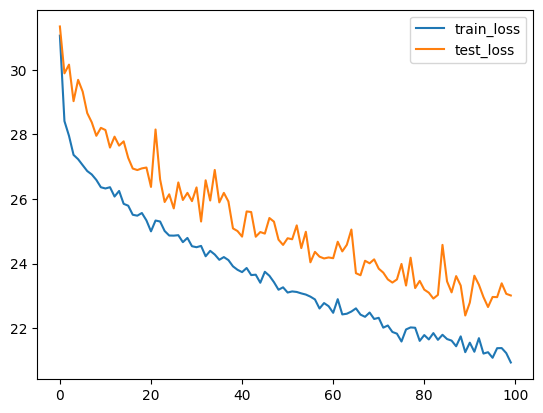

In [294]:
plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), test_loss, label='test_loss')
plt.legend()

In [295]:
# 预测全部 批次预测
result = [model(x.cuda()).cpu().detach().numpy() for x,_ in test_dl]

np.concatenate(result)

array([211.54596 , 130.48566 ,  87.5773  , ...,  55.43631 , 127.400314,
        70.572586], dtype=float32)

In [296]:
# 预测单个 5天预测后一天
data_last = data.iloc[-120:,:]
data_last = np.expand_dims(data_last.values, 0) # 增加batch位 规范

In [308]:
data_last = torch.from_numpy(data_last).float() 

data_pred = model(data_last.cuda())

In [309]:
data_pred

tensor(46.3630, device='cuda:0', grad_fn=<SqueezeBackward0>)